First of all, a few notes:
* As before, no code hints. We trust your skills (if in doubt - check the seminar notebook).
* Remember to submit the feedback! Especially if the homework was too difficult or easy for you.

# Introduction <font color=#c30>**[1.0]**</font>




## scRNA-seq

We **must** know our data before doing the analysis. To ease your life, [here](https://www.singlecellcourse.org/introduction-to-single-cell-rna-seq.html) is an excellent state-of-the-art description of the scRNA-seq experiments. Read it and answer the following questions:

* <font color=#c30>**[0.2]**</font> What is single-cell RNA-seq and how does it compare to bulk RNA-seq?

→

* <font color=#c30>**[0.2]**</font>  What are some of the typical applications of scRNA-seq?

→

* <font color=#c30>**[0.2]**</font>  What experimental design choices should be considered in scRNA-seq?

→

* <font color=#c30>**[0.2]**</font>  What are some of the challenges of scRNA-seq data compared to bulk data?

→

## Target experiment

To move on, you need to find/choose and download your favorite scRNA-seq dataset. Similar to what we did during the workshop, but everyone will have their own data to make it more fun.

See, for example, public [10x datasets](https://www.10xgenomics.com/resources/datasets?menu%5Bproducts.name%5D=Single%20Cell%20Gene%20Expression&query=&page=1&configure%5Bfacets%5D%5B0%5D=chemistryVersionAndThroughput&configure%5Bfacets%5D%5B1%5D=pipeline.version&configure%5BhitsPerPage%5D=50&configure%5BmaxValuesPerFacet%5D=1000&refinementList%5Bproduct.name%5D%5B0%5D=Single%20Cell%20Gene%20Expression) or [GEO](https://www.ncbi.nlm.nih.gov/gds/?term=scRNA-seq). Subsample cells or use more strict thresholds if the computations are too long.

* <font color=#c30>**[0.2]**</font>  Please provide a brief description of the chosen dataset. I.e., what was the purpose of the original study, what is the protocol, and so on. Insert link to the dataset.

→

# Main flow <font color=#c30>**[7.5]**</font>

Simple and tedious, you need to repeat the seminar results with your data and implement some algorithms by hand.

* <font color=#c30>**[2.5]**</font>  Repeat the main workflow: load & preprocess the data -> calculate PCA, UMAP, t-SNE -> color cells using K-means / Agg. Clustering / Leiden algorithms.





In [19]:
!wget https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_Controller/10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.tar.gz
!tar -xzf 10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.tar.gz

--2024-12-10 01:00:30--  https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_Controller/10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93346135 (89M) [application/x-tar]
Saving to: ‘10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.tar.gz’

10k_PBMC_3p_nextgem 100%[===================>]  89.02M   112MB/s    in 0.8s    

2024-12-10 01:00:31 (112 MB/s) - ‘10k_PBMC_3p_nextgem_Chromium_Controller_filtered_feature_bc_matrix.tar.gz’ saved [93346135/93346135]



In [20]:
!ls filtered_feature_bc_matrix

barcodes.tsv.gz  features.tsv.gz  matrix.mtx.gz


In [15]:
# current plt is not supported by the scanpy
!python3 -m pip uninstall -y matplotlib
!python3 -m pip install matplotlib==3.6.3 scanpy

Found existing installation: matplotlib 3.6.3
Uninstalling matplotlib-3.6.3:
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_install.py", line 722, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py", line 367, in remove
    for_rename = compress_for_rename(self._paths)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_uninstall.py", line 128, in compress_for_rename
    for dirname, subdirs, files in os.walk(root):
  File "/usr/lib/python3.10/os.py", line 419, in _walk
    yield from _walk(new_pa

In [21]:
import scanpy as sc

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3

adata = sc.read_10x_mtx(
    'filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',      # use gene symbols for the variable names (variables-axis index)
    cache=True                     # write a cache file for faster subsequent reading
)
# Make all gene names unique (symbols MUST be unique by but in reality...)
adata.var_names_make_unique()

adata

... writing an h5ad cache file to speedup reading next time


AnnData object with n_obs × n_vars = 11485 × 36601
    var: 'gene_ids', 'feature_types'

## Filtering

In [22]:
# Calculate common QC metrics (see docs for details)
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

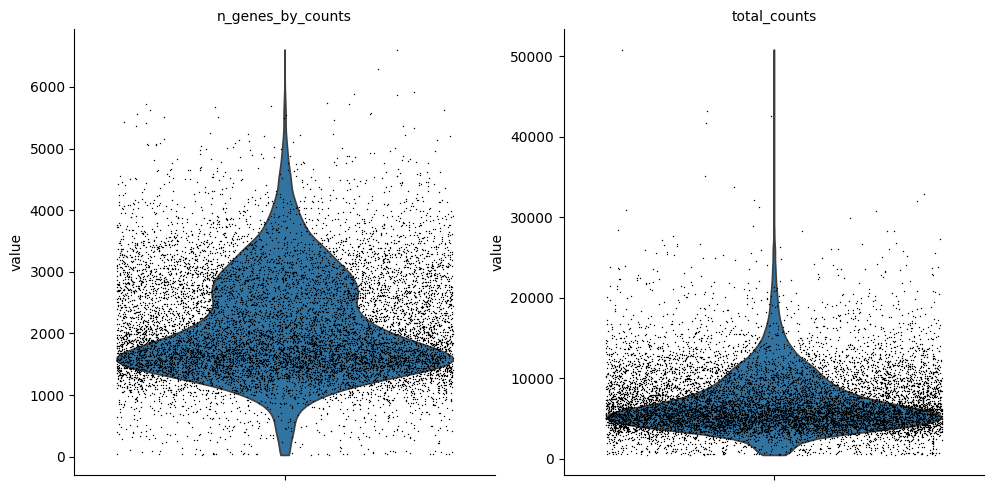

In [23]:
# Plot the result
sc.pl.violin(
    adata, ['n_genes_by_counts', 'total_counts'],
    jitter=0.4, multi_panel=True
)

In [24]:
# Warning! Very harsh thresholds to keep comp. time small
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=100)
adata

filtered out 528 cells that have less than 1000 genes expressed
filtered out 24028 genes that are detected in less than 100 cells


AnnData object with n_obs × n_vars = 10957 × 12573
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [25]:
adata.var

,gene_ids,feature_types,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
AL627309.5,ENSG00000241860,Gene Expression,473,0.043796,95.881585,503.0,470
LINC01409,ENSG00000237491,Gene Expression,743,0.071136,93.530692,817.0,731
LINC01128,ENSG00000228794,Gene Expression,558,0.051633,95.141489,593.0,540
LINC00115,ENSG00000225880,Gene Expression,119,0.010710,98.963866,123.0,118
FAM41C,ENSG00000230368,Gene Expression,131,0.011667,98.859382,134.0,130
...,...,...,...,...,...,...,...
MT-ND6,ENSG00000198695,Gene Expression,3889,0.502394,66.138441,5770.0,3744
MT-CYB,ENSG00000198727,Gene Expression,11482,45.538181,0.026121,523006.0,10957
AL592183.1,ENSG00000273748,Gene Expression,975,0.090727,91.510666,1042.0,966
AC240274.1,ENSG00000271254,Gene Expression,253,0.023248,97.797127,267.0,253


In [26]:
adata.obs['n_genes']

,n_genes
AAACCCAAGGTAGTCG-1,1749
AAACCCACAATCCAGT-1,3742
AAACCCACACCGTCTT-1,2110
AAACCCACATAGATCC-1,1452
AAACCCACATCTCATT-1,2992
...,...
TTTGTTGGTTTACGTG-1,1128
TTTGTTGTCCACAGGC-1,2080
TTTGTTGTCCCGAGGT-1,3396
TTTGTTGTCTGTACAG-1,1526


In [27]:
mask = adata.var_names.str.startswith('MT-')
print(f"Mito genes: {adata.var_names[mask].tolist()}")

adata.var['mt'] = mask

Mito genes: ['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


In [28]:
# Calculate common QC metrics (see docs for details)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

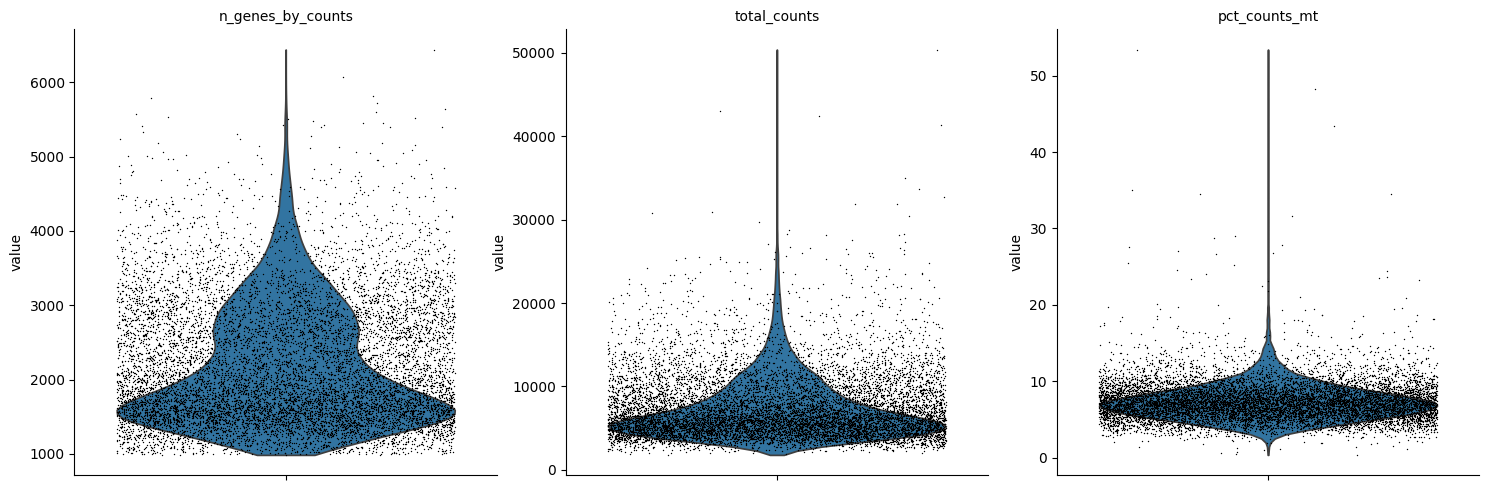

In [29]:
# Plot the result
sc.pl.violin(
    adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True
)

In [30]:
# Apply filters
adata = adata[adata.obs.n_genes_by_counts < 4_500, :]
adata = adata[adata.obs.total_counts < 24_000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata

View of AnnData object with n_obs × n_vars = 9672 × 12573
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mt'

In [31]:
# Normalize the data to CPM & take the log
sc.pp.normalize_total(adata, target_sum=1e6) # sum(cell counts) = 1e6
sc.pp.log1p(adata)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


We aren't done yet. Before moving on, we need to eliminate genes that are, in some sense, too ordinary. For example, the expression of housekeeping genes and other low-variance genes is comparable in many cells. Therefore their information value is negligible, and we can save a lot of computations by removing them early on.

In [32]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=7, min_disp=0.5)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


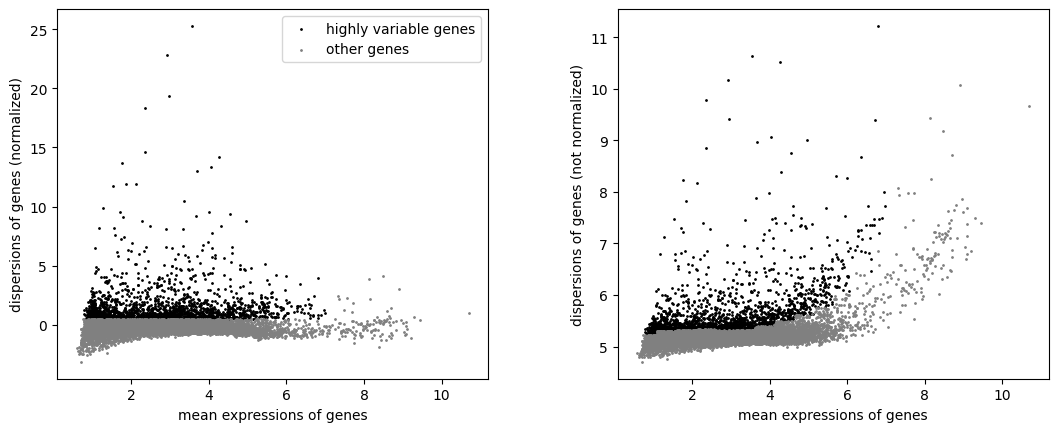

In [33]:
sc.pl.highly_variable_genes(adata)

In [34]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 9672 × 1825
    obs: 'n_genes_by_counts', 'total_counts', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [35]:
sc.pp.scale(adata, max_value=10) # clip values > 10

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Manifold Learning

In [36]:
import numpy as np
# Subsample to speed up the analysis
ind = np.random.choice(np.arange(len(adata.X)), 2_000, replace=False)

X = adata.X[ind].copy()
print(f"Cells vs Genes: {X.shape}")

Cells vs Genes: (2000, 1825)


In [37]:
from sklearn.manifold import Isomap, MDS, TSNE, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.decomposition import PCA

# Set of models to work with
embeddings = {
    "Isomap embedding": Isomap(n_components=2),
    "MDS embedding": MDS(n_components=2, n_init=1, max_iter=100),
    "t-SNE embedding": TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42),
    "Spectral embedding": SpectralEmbedding(n_components=2, random_state=32),
    "LLE embedding": LocallyLinearEmbedding(n_components=2, method="modified"),
    "PCA": PCA(n_components=2)
}

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


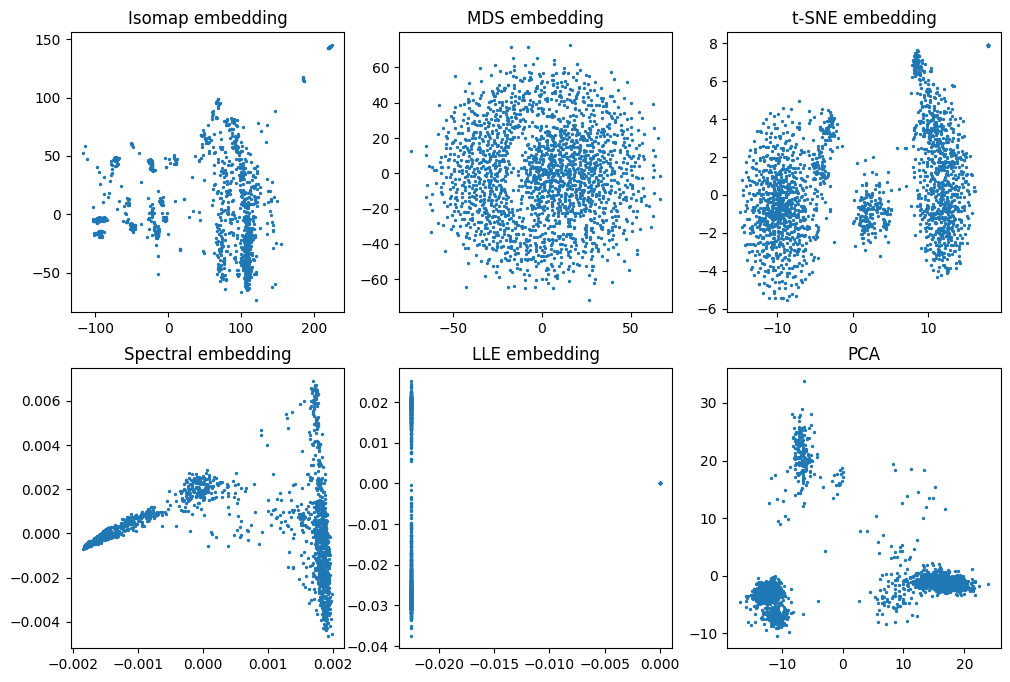

In [38]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

assert len(axes) == len(embeddings)

for ax, (name, model) in zip(axes, embeddings.items()):
  ax.set_title(name)
  transformed = model.fit_transform(X)
  ax.scatter(transformed[:, 0], transformed[:, 1], s=2)

computing PCA
    with n_comps=50
    finished (0:00:05)


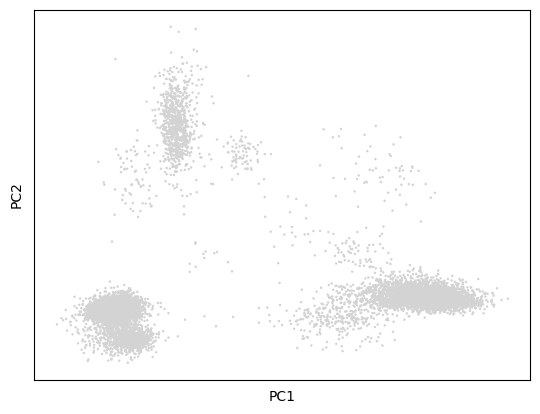

In [39]:
sc.tl.pca(adata)
sc.pl.pca(adata)

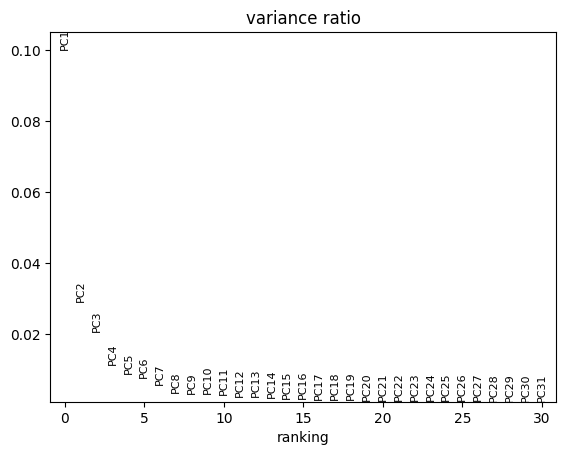

In [40]:
sc.pl.pca_variance_ratio(adata)

In [41]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:18)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:22)


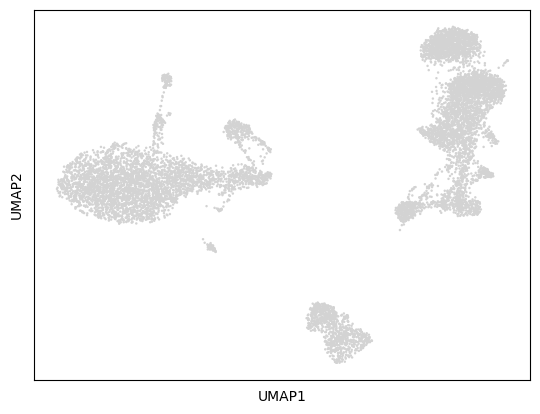

In [42]:
sc.pl.umap(adata)

## Clustering


* <font color=#c30>**[1]**</font>  Make several plots showing how the representation of data is changing for UMAP & t-SNE by tweaking parameters of those algorithms. For the representation of your choice, find optimal number of clusters by tweaking `n_clusters` in K-means and `resolution` in Leiden algorithm. What was the optimal number of clusters for your dataset? Justify your choice.

In [ ]:
# your code here

* <font color=#c30>**[1.5]**</font>  Analyze your clusters and identify if any of them is an outlier in terms of technical scRNA characteristics, such as:  number of UMIs per cell, number of genes per cell, percentage of mitochondrial expression? Are there any clusters with high doublet scores? Make relevant visualizations showcasing those differences.

  * If there are, what is the best way to deal with them? Are the differences between the cluster you selected and the other clusters reliable?


In [ ]:
# your code here

* <font color=#c30>**[1]**</font>  Visualize `10` top expressed genes in each cluster. To do this, make use of:
1. `sc.tl.rank_genes_groups` to rank genes for characterizing groups (cluster labels).
  * [Hint] The default statistical method in `rank_gene_groups` is t-test. Think of whether this method is the correct choice here (e.g. Do we have normal distributions in our data?), look up what options do you have in this fuction, and change it if you see the need to do so.
  * [Hint] Also read about `Tie_correct` parameter.
2. `sc.pl.rank_genes_groups` to plot ranking of genes for each cluster.
3. `sc.pl.rank_genes_groups_heatmap` to plot ranking of genes using heatmap plot.\
  * [Hint] Instead of the heatmap, you might want to use some other visualization that you find most fitting. You can use [this tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/plotting/core.html) to find more info about scanpy plotting functions.


In [ ]:
# your code here

* <font color=#c30>**[1.5]**</font>  Do one of the following:
  * Either provide formal algorithm and implementation of K-means with random initialization by hand, describe results, and compare them to the sklearn implementation.
  * Or do the same for PCA.\
    *Note that completing both assignments does NOT result in [3.0] points.*

In [ ]:
# your code here

# Extra points <font color=#c30>**[1.5]**</font>



* <font color=#c30>**[1.4]**</font>  Choose 3 clusters of interest and try to make a guess about their cell type based on the top-expressed genes. For example, look for information on whether such high expression of a certain gene is typical of some cell type.
  * Blind answers from ChatGPT won't be accepted. Please look for information from multiple sources, cite them/insert links, and formulate your own opinion.
  * You can also use automatic annotators like Azimuth and Symphony for the whole dataset, but probably it will take much longer time to figure out how they work.

In [ ]:
# your code here



You worked hard to get here, and we hope you learned something new!
Each year we gather impressions and suggestions regarding our course in order to improve it. Find time to write a review here or in anonymous form (can be found on github course page).

The last task:

* <font color=#c30>**[0.1]**</font>  To greatly increase the chances of your success in the bioinformatics field, find a funny meme (about your favourite subject, like ML, molecular biology, etc.) and attach it here.

** your meme here **